In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import datetime

sbn.set()

### Model the Bandit

In [2]:
class OneBandit:
    
    def __init__(self):
        np.random.seed(np.random.randint(0, 2**32-1))
        self._actual_reward = np.random.randn()
        
    def pull_the_lever(self):
        return np.random.randn() + self._actual_reward
        

### Let's check a sample distribution of executing this Bandit

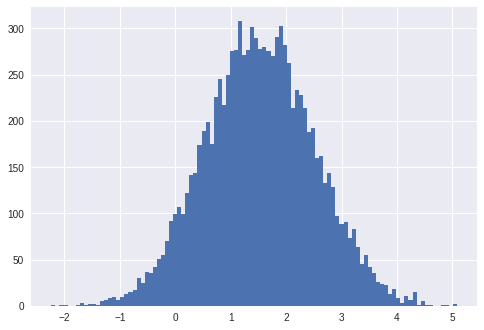

1.5262357052350983


In [3]:
ob = OneBandit()
data = []
for i in range(10000):
    data.append(ob.pull_the_lever())
    
plt.hist(data, bins=100)
plt.show()
print(ob._actual_reward)

### Create K such Bandits

In [4]:
class KBandits:
    
    def __init__(self, k=10):
        self._bandits = []
        self._k = k
        
        self.bestReward = 0
        self.bestAction = -1
        
        for i in range(k):
            self._bandits.append(OneBandit())
            if self._bandits[i]._actual_reward > self.bestReward:
                self.bestReward = self._bandits[i]._actual_reward
                self.bestAction = i
    
    def show_actual_rewards(self):
        for i in range(self._k):
            print("Bandit: {} Actual Reward: {}".format(i, self._bandits[i]._actual_reward))
            
    def pull_the_lever(self, bandit_index_0based):
        return self._bandits[bandit_index_0based].pull_the_lever()
    

### Let's check a sample distribution of executing this Bandit

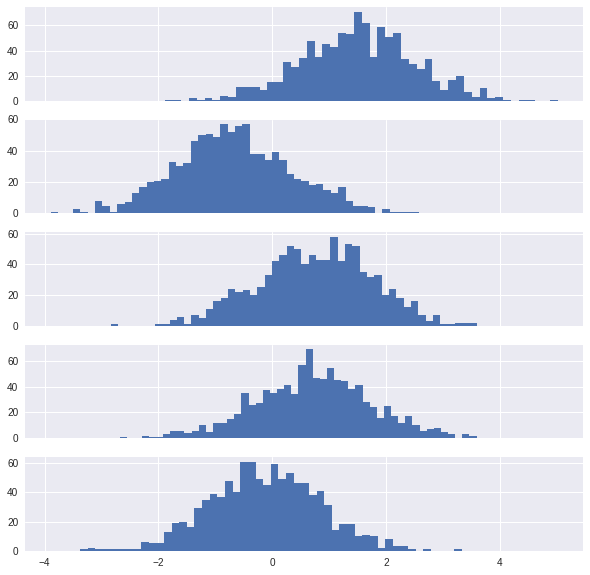

In [5]:
kb = KBandits(k=5)

kdata = []

for k in range(kb._k):
    data = []
    for i in range(1000):
        data.append(kb.pull_the_lever(k-1))
    kdata.append(data)

f, axes = plt.subplots(kb._k, sharex=True)

for k in range(kb._k):
    axes[k].hist(kdata[k], bins=50)
    
#f.subplots_adjust(hspace=0)
f.set_size_inches(10, 10)
plt.show()

### Solving the K-Arm Bandit problem

Simple solution

* Let's apply a tabular method to solve the bandit (i.e. to learn which leaver to press to get max returns)
* There is only one state per bandit
* Environment is stationary
* We estimate the action values by playing OAB over many iterations
* We use epsilon-greedy approach to achive exploitation expolration balance
* This gives is the estimated reward for each action



In [6]:
def k_arm_bandit(num_bandits, epsilon, num_iterations, init_action_value):
    
    kb = KBandits(k=num_bandits)
    
    action_values = [init_action_value for _ in range(num_bandits)]
    action_count  = [0 for _ in range(num_bandits)]
    
    bestActionCounts = np.zeros(num_iterations, dtype='float')
    averageRewards = np.zeros(num_iterations, dtype='float')

    reward_average = 0
    stepSize = 0.1
    step = 0

    for i in range(num_iterations):

        action = -1
        if np.random.binomial(1, epsilon) == 1:
            action = np.random.randint(0, num_bandits)
        else:
            action = np.argmax(action_values)

        reward = kb.pull_the_lever(action)

        step += 1
        #reward_average = (step - 1.0) / step * reward_average + reward / step
        averageRewards[i] = reward
        if action == kb.bestAction:
            bestActionCounts[i] += 1

        action_count[action] += 1
        action_values[action] = action_values[action] + stepSize * (reward - action_values[action])


    return action_values, kb, bestActionCounts, averageRewards

    

In [7]:
def k_arm_bandit_simulation(num_bandits, num_kbandits, num_iterations, epsilons, init_action_value):
    bestActionCounts = [np.zeros(num_iterations, dtype='float') for _ in epsilons]
    averageRewards = [np.zeros(num_iterations, dtype='float') for _ in epsilons]

    for ie, epsilon in enumerate(epsilons):

        for num_kbandit in range(num_kbandits):
            action_values, kb, bac, ar = k_arm_bandit(num_bandits, epsilon, num_iterations, init_action_value)
            bestActionCounts[ie] += bac
            averageRewards[ie] += ar

        bestActionCounts[ie] /= num_kbandits;
        averageRewards[ie] /= num_kbandits;
        
    return bestActionCounts, averageRewards

In [8]:
num_bandits = 10
num_kbandits = 2000
num_iterations = 1000
epsilons = [0, 0.01, 0.1]
init_action_value = 0

bestActionCounts, averageRewards = k_arm_bandit_simulation(num_bandits, num_kbandits, 
                                                           num_iterations, epsilons, init_action_value)

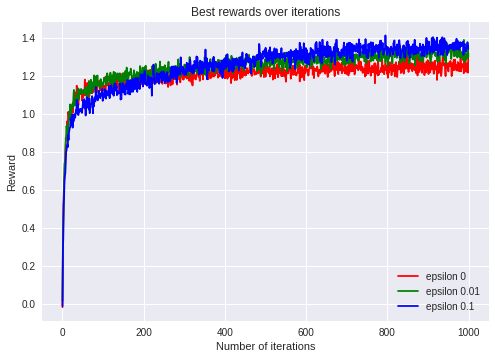

In [9]:
plt.plot(range(num_iterations), averageRewards[0], c='red', label='epsilon 0')
plt.plot(range(num_iterations), averageRewards[1], c='green', label='epsilon 0.01')
plt.plot(range(num_iterations), averageRewards[2], c='blue', label='epsilon 0.1')
plt.legend()
plt.title('Best rewards over iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Reward')
plt.show()


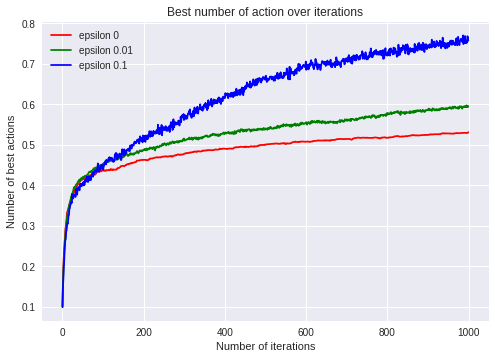

In [10]:
plt.plot(range(num_iterations), bestActionCounts[0], c='red', label='epsilon 0')
plt.plot(range(num_iterations), bestActionCounts[1], c='green', label='epsilon 0.01')
plt.plot(range(num_iterations), bestActionCounts[2], c='blue', label='epsilon 0.1')
plt.legend()
plt.title('Best number of action over iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Number of best actions')
plt.show()


### Optimistic Initial Values

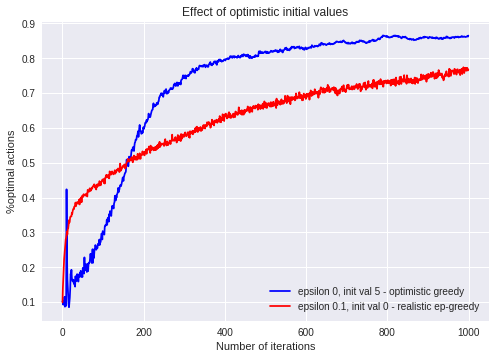

In [11]:
num_bandits = 10
num_kbandits = 2000
num_iterations = 1000
epsilons = [0]
init_action_value = 5

bestActionCounts, averageRewards = k_arm_bandit_simulation(num_bandits, num_kbandits, num_iterations, 
                                                           epsilons, init_action_value)

plt.plot(range(num_iterations), bestActionCounts[0], c='blue', label='epsilon 0, init val 5 - optimistic greedy')

epsilons = [0.1]
init_action_value = 0
bestActionCounts, averageRewards = k_arm_bandit_simulation(num_bandits, num_kbandits, num_iterations, 
                                                           epsilons, init_action_value)

plt.plot(range(num_iterations), bestActionCounts[0], c='red', label='epsilon 0.1, init val 0 - realistic ep-greedy')

plt.legend()
plt.title('Effect of optimistic initial values')
plt.xlabel('Number of iterations')
plt.ylabel('%optimal actions')
plt.show()


### Upper Confidence Bound Action Selection

* Just like Optimistic initial value
* The optimistic mean (UCB) is given by argmax of:

In [12]:
# mean is the current estimated mean of the jth bandit, n is the number of iterations, 
# nj is the number of iterations of the jth bandit

def ucb(mean, n, nj):
  if nj == 0:
    return float('inf')
  return mean + np.sqrt(2*np.log(n) / nj)


### Gradient Bandit

In [13]:
# TODO

### Bayesian/Thomson sampling

In [14]:
# TODO

Ref: http://incompleteideas.net/sutton/book/the-book-2nd.html